<a href="https://colab.research.google.com/github/Phoenix23111/Advanced_AI_Assignment/blob/master/Advanced_AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# SETTINGS
BATCH_SIZE = 128
EPOCHS = 3
LR = 1e-3
MIXUP_ALPHA = 0.3
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [ ]:

# DATASETS (MNIST + FashionMNIST)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load datasets
mnist_train = datasets.MNIST(root="data", train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

fmnist_train = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
fmnist_test  = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)

# Combine train domains for training (source domains)
train_dataset = ConcatDataset([mnist_train, fmnist_train])
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Create test loaders for each domain (to evaluate generalization)
test_loaders = {
    "MNIST": DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True),
    "FashionMNIST": DataLoader(fmnist_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
}

print("Train size:", len(train_dataset), "MNIST test:", len(mnist_test), "FashionMNIST test:", len(fmnist_test))


Train size: 120000 MNIST test: 10000 FashionMNIST test: 10000


In [ ]:

# MODEL: ResNet18 adapted for 1-channel input

def get_resnet18(num_classes=10, pretrained=False):
    model = models.resnet18(weights=None if not pretrained else models.ResNet18_Weights.DEFAULT)
    # change first conv to accept 1 channel
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# quick sanity
test_model = get_resnet18()
print(test_model)
del test_model


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# MIXUP helpers
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha <= 0:
        return x, y, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a = y
    y_b = y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(pred, y_a, y_b, lam, criterion):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
# TRAIN & EVAL functions
def train_one_epoch(model, loader, optimizer, criterion, use_mixup=False):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        if use_mixup:
            x_m, y_a, y_b, lam = mixup_data(x, y)
            outputs = model(x_m)
            loss = mixup_criterion(outputs, y_a, y_b, lam, criterion)
            preds = outputs.argmax(dim=1)  # for general logging
        else:
            outputs = model(x)
            loss = criterion(outputs, y)
            preds = outputs.argmax(dim=1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        total += x.size(0)
        # count approximate accuracy
        correct += (preds == y).sum().item()
    return running_loss / total, correct / total

def evaluate(model, loader, criterion=None):
    model.eval()
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            total += y.size(0)
            correct += (preds == y).sum().item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    acc = correct / total
    if all_preds:
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
    else:
        all_preds = np.array([])
        all_labels = np.array([])
    return acc, all_preds, all_labels


In [ ]:
# TRAINING PIPELINE that runs ERM and Mixup experiments
def run_experiment(use_mixup=False, epochs=EPOCHS):
    model = get_resnet18(num_classes=10)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": []}
    start_time = time.time()

    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, train_loader, optimizer, criterion, use_mixup=use_mixup)
        history["train_loss"].append(loss)
        history["train_acc"].append(acc)
        print(f"[{'Mixup' if use_mixup else 'ERM'}] Epoch {epoch+1}/{epochs}  Loss: {loss:.4f}  TrainAcc(approx): {acc*100:.2f}%")
    elapsed = time.time() - start_time
    print("Training finished in {:.1f}s".format(elapsed))

    # Evaluate on each test domain
    results = {}
    all_preds = {}
    all_labels = {}
    for name, loader in test_loaders.items():
        acc, preds, labels = evaluate(model, loader)
        results[name] = acc
        all_preds[name] = preds
        all_labels[name] = labels
        print(f"Eval on {name}: Accuracy = {acc*100:.2f}%")
    return model, history, results, all_preds, all_labels

print("=== Running ERM baseline ===")
erm_model, erm_hist, erm_results, erm_preds, erm_labels = run_experiment(use_mixup=False, epochs=EPOCHS)
print("\n=== Running Mixup experiment ===")
mix_model, mix_hist, mix_results, mix_preds, mix_labels = run_experiment(use_mixup=True, epochs=EPOCHS)


=== Running ERM baseline ===
[ERM] Epoch 1/3  Loss: 0.2781  TrainAcc(approx): 90.21%
[ERM] Epoch 2/3  Loss: 0.1495  TrainAcc(approx): 94.75%
[ERM] Epoch 3/3  Loss: 0.1242  TrainAcc(approx): 95.61%
Training finished in 1009.3s
Eval on MNIST: Accuracy = 98.79%
Eval on FashionMNIST: Accuracy = 91.29%

=== Running Mixup experiment ===
[Mixup] Epoch 1/3  Loss: 0.7002  TrainAcc(approx): 49.03%
[Mixup] Epoch 2/3  Loss: 0.5278  TrainAcc(approx): 54.76%
[Mixup] Epoch 3/3  Loss: 0.4863  TrainAcc(approx): 52.32%
Training finished in 1013.3s
Eval on MNIST: Accuracy = 99.21%
Eval on FashionMNIST: Accuracy = 92.08%


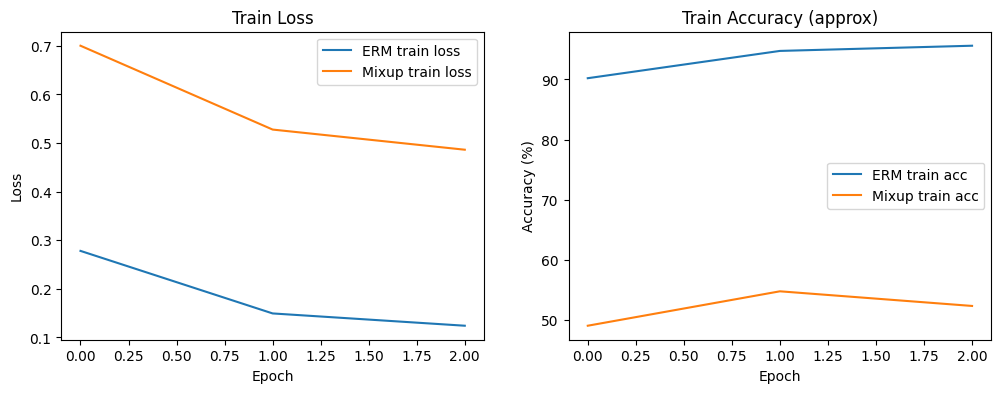

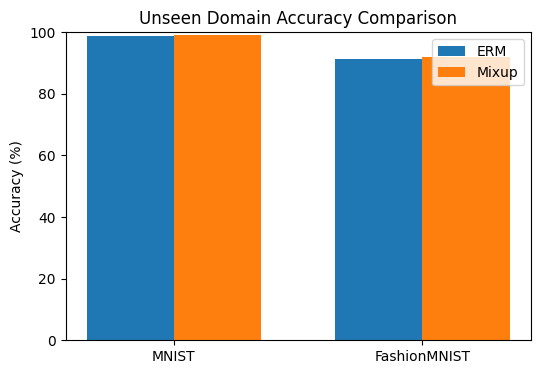

In [ ]:
# PLOTTING: loss & accuracy curves and per-domain comparison
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(erm_hist["train_loss"], label="ERM train loss")
plt.plot(mix_hist["train_loss"], label="Mixup train loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Train Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot([a*100 for a in erm_hist["train_acc"]], label="ERM train acc")
plt.plot([a*100 for a in mix_hist["train_acc"]], label="Mixup train acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Train Accuracy (approx)"); plt.legend()
plt.show()

# bar chart: evaluation per domain
domains = list(test_loaders.keys())
erm_accs = [erm_results[d]*100 for d in domains]
mix_accs = [mix_results[d]*100 for d in domains]

x = np.arange(len(domains))
width = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - width/2, erm_accs, width, label='ERM')
plt.bar(x + width/2, mix_accs, width, label='Mixup')
plt.ylabel('Accuracy (%)'); plt.title('Unseen Domain Accuracy Comparison'); plt.xticks(x, domains); plt.legend()
plt.ylim(0,100)
plt.show()


Classification report (Mixup) on MNIST
              precision    recall  f1-score   support

           0      0.996     0.996     0.996       980
           1      0.990     0.997     0.994      1135
           2      0.995     0.989     0.992      1032
           3      0.994     0.992     0.993      1010
           4      0.991     0.997     0.994       982
           5      0.993     0.991     0.992       892
           6      0.992     0.993     0.992       958
           7      0.975     0.993     0.984      1028
           8      0.998     0.989     0.993       974
           9      0.998     0.983     0.991      1009

    accuracy                          0.992     10000
   macro avg      0.992     0.992     0.992     10000
weighted avg      0.992     0.992     0.992     10000



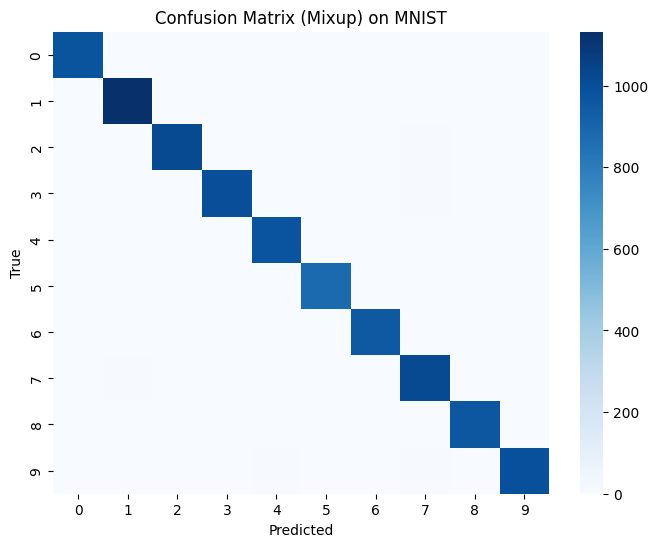

In [ ]:
# Confusion Matrix and Classification Report on MNIST
from sklearn.metrics import ConfusionMatrixDisplay

target_domain = "MNIST"
preds = mix_preds[target_domain]
labels = mix_labels[target_domain]

if preds.size:
    print("Classification report (Mixup) on", target_domain)
    print(classification_report(labels, preds, digits=3))
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Mixup) on {target_domain}')
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()
else:
    print("No predictions available for", target_domain)


Classification report (Mixup) on FashionMNIST
              precision    recall  f1-score   support

           0      0.874     0.871     0.872      1000
           1      0.995     0.980     0.987      1000
           2      0.938     0.854     0.894      1000
           3      0.909     0.936     0.922      1000
           4      0.836     0.943     0.886      1000
           5      0.991     0.983     0.987      1000
           6      0.799     0.751     0.774      1000
           7      0.904     0.995     0.947      1000
           8      0.983     0.982     0.982      1000
           9      0.995     0.913     0.952      1000

    accuracy                          0.921     10000
   macro avg      0.922     0.921     0.921     10000
weighted avg      0.922     0.921     0.921     10000



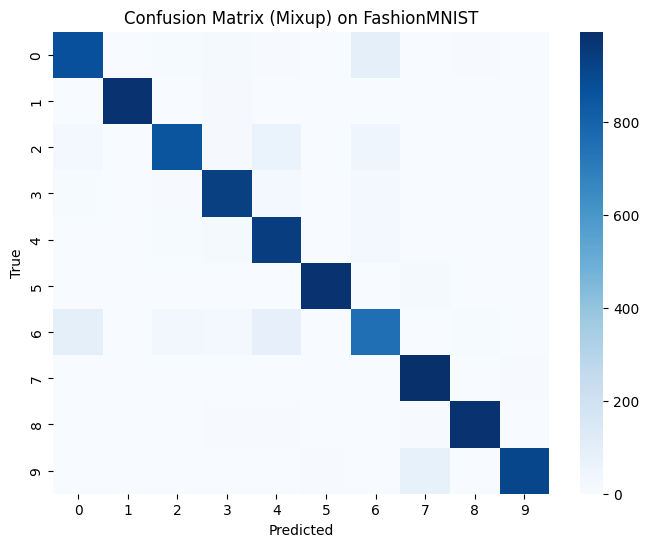

In [ ]:
# Confusion Matrix and Classification Report on FashionMNIST
from sklearn.metrics import ConfusionMatrixDisplay

target_domain = "FashionMNIST"
preds = mix_preds[target_domain]
labels = mix_labels[target_domain]

if preds.size:
    print("Classification report (Mixup) on", target_domain)
    print(classification_report(labels, preds, digits=3))
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Mixup) on {target_domain}')
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()
else:
    print("No predictions available for", target_domain)


In [ ]:

# Save models

torch.save(erm_model.state_dict(), "erm_resnet18.pth")
torch.save(mix_model.state_dict(), "mixup_resnet18.pth")
print("Models saved.")


Models saved.
